In [1]:
import dit
import os

import numpy as np
import pandas as pd
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc

from dit import ScalarDistribution

import matplotlib.pyplot as plt
%matplotlib inline

from src.data_loader import Shifted_Data_Loader


Using TensorFlow backend.


In [13]:
proj_root = '/home/elijahc/projects/vae'
models_root = os.path.join(proj_root,'models')
dates = ['2019-01-{}'.format(n) for n in np.arange(10)+14]
paths = [os.path.join(models_root,d) for d in dates]
trans_amt = np.arange(10)/10
fa_10_iso_df = pd.read_pickle('../data/style_embeddings/fashion_mnist_isomap_10_neighbor.pk').set_index('test_idx').sort_index()
isos = fa_10_iso_df.isomap_dim_1.values

paths

['/home/elijahc/projects/vae/models/2019-01-14',
 '/home/elijahc/projects/vae/models/2019-01-15',
 '/home/elijahc/projects/vae/models/2019-01-16',
 '/home/elijahc/projects/vae/models/2019-01-17',
 '/home/elijahc/projects/vae/models/2019-01-18',
 '/home/elijahc/projects/vae/models/2019-01-19',
 '/home/elijahc/projects/vae/models/2019-01-20',
 '/home/elijahc/projects/vae/models/2019-01-21',
 '/home/elijahc/projects/vae/models/2019-01-22',
 '/home/elijahc/projects/vae/models/2019-01-23']

In [15]:
isos.shape

(10000,)

In [2]:

# tx_vals = np.arange(10)/10.
# z_dfs = [pd.read_pickle(os.path.join(data_root,'merge_{}.pk'.format(tx))) for tx in tx_vals]


In [10]:
z_encodings = np.array([np.load(os.path.join(p,'layer_activations','z_enc.npy')) for p in paths])
dense_1 = np.array([np.load(os.path.join(p,'layer_activations','dense_1.npy')) for p in paths])
dense_2 = np.array([np.load(os.path.join(p,'layer_activations','dense_2.npy')) for p in paths])

dxs = np.array([np.load(os.path.join(p,'layer_activations','dx.npy')) for p in paths])-14
dys = np.array([np.load(os.path.join(p,'layer_activations','dy.npy')) for p in paths])-14
cids = np.array([np.load(os.path.join(p,'layer_activations','y_train.npy')) for p in paths])
dfs = [pd.DataFrame.from_records({'dx':dxs[i],'dy':dys[i],'class_id':cids[i],'eccentricity':[tx]*10000}) for i,tx in enumerate(trans_amt) ]

In [34]:
sub_dfs = []
for cid in np.arange(10):
    c_idxs = fa_10_iso_df.class_id.values==cid
    subset_df = fa_10_iso_df[c_idxs]
    scaler = MinMaxScaler(feature_range=(-14,14))
    sc_isos = scaler.fit_transform(isos[c_idxs].reshape(-1,1)).flatten()
    subset_df['scaled_isomap_dim_1'] = sc_isos
    sub_dfs.append(subset_df)

fa_10_iso_df = pd.concat(sub_dfs,axis=0).sort_index()
iso = np.array([fa_10_iso_df.isomap_dim_1.values.tolist() for _ in np.arange(10)])

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
class RunResult():
    def __init__(self,z_encodings,dx,dy,iso,class_id):
        self.z_encoding_raw = z_encodings
        self.z_dim = z_encodings.shape[-1]
        self.dx = dx
        self.dy = dy
        self.isomap_1D_raw = iso
        self.class_id = class_id
        
    def z_enc(self,feat_range=50):
        z_n = [self.z_encoding_raw[:,n] for n in np.arange(self.z_dim)]
        return [MinMaxScaler(feature_range=(0,feat_range)).fit_transform(nvec.reshape(-1,1)).flatten().astype(int) for nvec in z_n]

    def iso(self,feat_range=50):
        return MinMaxScaler(feature_range=(0,feat_range)).fit_transform(self.isomap_1D_raw.reshape(-1,1)).flatten().astype(int)
    
    def z_enc_joint_dist(self,X):

        n_vec = [Counter(zip(n,X)) for n in self.z_enc()]
        n_pmf = [{k:v/float(sum(C.values())) for k,v in C.items()} for C in n_vec]
        n_cdists = [dit.Distribution(d) for d in n_pmf]
    #     n_dists = [ScalarDistribution(d) for d in n_pmf]

        return n_cdists
    
    def entropy(self,X):
        jdists = self.z_enc_joint_dist(X)
        
        return [dit.shannon.entropy(d) for d in jdists]
    
    def mutual_info(self,X):
        jdists = self.z_enc_joint_dist(X)
        
        return [dit.shannon.mutual_information(d,[0],[1]) for d in jdists]
        
    def conditional_entropy(self,X):
        jdists = self.z_enc_joint_dist(X)
        
        cond_H = [dit.shannon.mutual_information(d,[1],[0]) for d in jdists]
        
        return cond_H


# n,dx = make_joint_dists(z_encodings[3],dxs[3])

In [36]:
result_set = [RunResult(z_encodings[i],dxs[i],dys[i],iso[i],cids[i]) for i in np.arange(10)]

In [37]:
z_dx_I = [rr.mutual_info(rr.dx) for rr in result_set]

In [38]:
z_dy_I = [rr.mutual_info(rr.dy) for rr in result_set]

In [39]:
z_iso_I = [rr.mutual_info(rr.iso(feat_range=50)) for rr in result_set]

In [40]:
z_class_I = [rr.mutual_info(rr.class_id) for rr in result_set]

In [41]:
z_I_df = [pd.DataFrame.from_records({'dx':x,'dy':y,'style':i,'class':c}) for x,y,i,c in zip(z_dx_I,z_dy_I,z_iso_I,z_class_I)]

In [42]:
for df,tx in zip(z_I_df,trans_amt):
    df['translation']=tx
    df['xcov']=10

In [43]:
# pd.concat(z_I_df).to_pickle('../data/style_embeddings/z_I.pk')

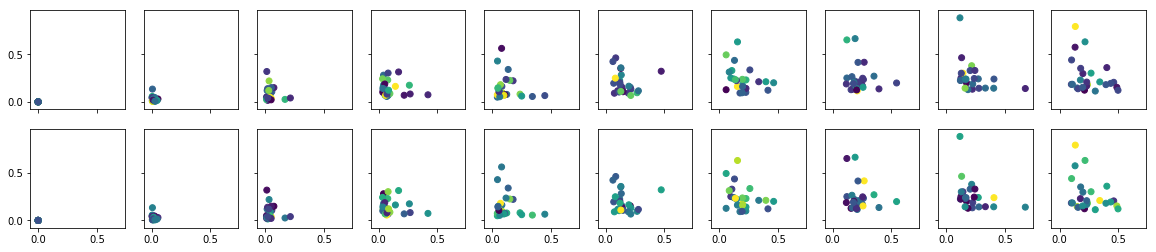

In [44]:
fig,axs = plt.subplots(2,10,figsize=(20,4),sharey=True,sharex=True)
# ax.set_ylim(-0.1,0.8)
# ax.set_xlim(-0.1,0.8)
df = z_I_df[6]
points = []
for df,i in zip(z_I_df,np.arange(10)):
    pts_0 = axs[0,i].scatter(df['dx'],df['dy'],c=df['class'],cmap='viridis')
    pts_1 = axs[1,i].scatter(df['dx'],df['dy'],c=df['style'],cmap='viridis')
    
# plt.colorbar(points[0])
# sns.scatterplot(x='dx',y='dy',hue='class',data=z_I_df[5],palette='plasma',legend=False)

In [14]:
# z_I_df = [df['spatial_var']=tx for df,tx in zip(z_I_df,tx_vals)]

In [15]:
rr = result_set[5]

Text(0,0.5,'Avg Mutual Info')

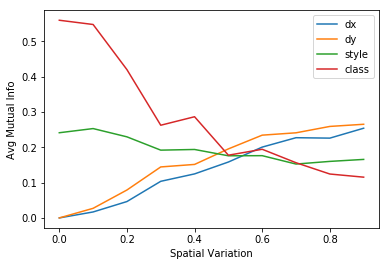

In [45]:
tx_vals = trans_amt
plt.plot(tx_vals,np.array(z_dx_I).mean(axis=1))
plt.plot(tx_vals,np.array(z_dy_I).mean(axis=1))
plt.plot(tx_vals,np.array(z_iso_I).mean(axis=1))
plt.plot(tx_vals,np.array(z_class_I).mean(axis=1))
plt.legend(['dx','dy','style','class'])
plt.xlabel('Spatial Variation')
plt.ylabel('Avg Mutual Info')

In [ ]:
import seaborn as sns
sns.set_context('talk')
fig,axs = plt.subplots(4,10,sharex=True,sharey=True,figsize=(20,6))
for fx,fy,fisos,fclass,i in zip(z_dx_I,z_dy_I,z_iso_I,z_class_I,np.arange(10)):
    axs[0,i].scatter(np.arange(25),sorted(fx,reverse=True))
    axs[1,i].scatter(np.arange(25),sorted(fy,reverse=True))
    axs[2,i].scatter(np.arange(25),sorted(fisos,reverse=True))
    axs[3,i].scatter(np.arange(25),sorted(fclass,reverse=True))

    axs[0,0].set_ylabel('I(dX|Z)')
    axs[1,0].set_ylabel('I(dY|Z)')
    axs[2,0].set_ylabel('I(S|Z)')
    axs[3,0].set_ylabel('I(C|Z)')
    
    for ax in axs[3]:
        ax.set_xticks([])
plt.tight_layout()

plt.savefig('../figures/2019-01-28/unit_shanon_waterfall.png')

In [ ]:
plt.plot(tx_vals,[auc(np.arange(25)/25.0,z_dx_I[i]) for i in np.arange(10)])
plt.plot(tx_vals,[auc(np.arange(25)/25.0,z_dy_I[i]) for i in np.arange(10)])
plt.plot(tx_vals,[auc(np.arange(25)/25.0,z_iso_I[i]) for i in np.arange(10)])
plt.plot(tx_vals,[auc(np.arange(25)/25.0,z_class_I[i]) for i in np.arange(10)])
plt.legend(['dx','dy','style','class'])
plt.xlabel('Spatial Variation')
plt.ylabel('AUC ()')
plt.tight_layout()
plt.savefig('../figures/2019-01-28/shannon_auc_vs_spatial_variation.png')